In [60]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.datasets as datasets

In [61]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [62]:
# let’s initialize the MNIST train and test set.
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [63]:
train_batch_size = 6000
test_batch_size = 1000

In [64]:
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=test_batch_size, shuffle=False)

In [65]:
dataiter = iter(train_loader)
X_batch, y_batch = dataiter.next()

print(X_batch.shape)
print(y_batch.shape)

torch.Size([6000, 1, 28, 28])
torch.Size([6000])


tensor(5)


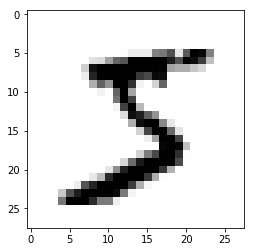

In [66]:
plt.imshow(X_batch[0].numpy().squeeze(), cmap='gray_r'); print(y_batch[0])

In [67]:
input_size = 784
hidden_layer = [250, 100]
output_size = 10

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_layer[0])
        self.linear2 = nn.Linear(hidden_layer[0], hidden_layer[1])
        self.linear3 = nn.Linear(hidden_layer[1], output_size)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.softmax(self.linear3(X), dim=1)
        return X
 
mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [68]:
def evaluate(model):
#model = mlp
    correct = 0 
    for test_imgs, test_labels in test_loader:
        
        test_imgs = Variable(test_imgs).float()
        test_imgs = torch.reshape(test_imgs, (test_batch_size, 784))
        
        output = model.forward(test_imgs)
        
        predicted = torch.max(output,1)[1]
        
        correct += (predicted == test_labels).sum()
        accuracy = float(correct*100) / (len(test_loader)*test_batch_size)
    
    #print("Test accuracy:{:.3f} % ".format(accuracy))
    return accuracy

In [69]:
def fit(model, train_loader, epochs, optimizer, loss):
    
    epochs_list = []
    loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    if optimizer == 'Adam': 
        # Adam optimizer
        optimizer = torch.optim.Adam(model.parameters()) # lr=0.001, betas=(0.9,0.999))
    
    if loss == 'CrossEntropy':
        # cross entropy function
        error = nn.CrossEntropyLoss()
        
    for epoch in range(epochs):
                
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # wrapping tensors in variables,  If x is a Variable then x.data is a Tensor giving its value, 
            # and x.grad is another Variable holding the gradient of x with respect to some scalar value
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            var_X_batch = torch.reshape(var_X_batch, (train_batch_size, 784))
                        
            # we need to set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()
            
            # output of the model
            output = model.forward(var_X_batch)
                        
            # Calculating the loss 
            loss = error(output, var_y_batch)
            
            # Let's do backpropogation, it will calculate all the gradients and save to x.grad
            loss.backward()
            
            # Performs a single optimization step,  
            #parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule
            optimizer.step()
            
            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            accuracy = float(correct*100) / float(train_batch_size*(batch_idx+1))
        
        # Training accuracy
        epochs_list.append(epoch)
        loss_list.append(loss.data)
        train_accuracy_list.append(accuracy)
        
        # Testing accuracy
        test_accuracy = evaluate(model)
        test_accuracy_list.append(test_accuracy)
        
        print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
            epoch+1, 
            (batch_idx+1)*(len(X_batch)), 
            len(train_loader.dataset), 
            100.*(batch_idx+1) / len(train_loader), 
            loss.data, 
            accuracy))
                                                  
    # accuracy Plot
    train_accuracy_array = np.array(train_accuracy_list)
    y_train_accuracy = train_accuracy_array.reshape(-1, 1)
    
    test_accuracy_array = np.array(test_accuracy_list)
    y_test_accuracy = test_accuracy_array.reshape(-1, 1)

    # Loss Plot
    loss_array_array = np.array(loss_list)
    y_loss = loss_array_array.reshape(-1, 1)
    
    x_epochs = np.array(epochs_list).reshape(-1, 1)
                                                  
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_epochs, y_loss)
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('epochs_vs_loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(x_epochs, y_train_accuracy, label='Training accuracy')
    plt.plot(x_epochs, y_test_accuracy, label='Testing accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('epochs_vs_accuracy')
    plt.legend()
    
    fig1 = plt.gcf()
    plt.show()

Epoch : 1 [60000/60000 (100%)]	Loss: 2.090410	 Accuracy:29.932%
Epoch : 2 [60000/60000 (100%)]	Loss: 1.850303	 Accuracy:58.480%
Epoch : 3 [60000/60000 (100%)]	Loss: 1.721335	 Accuracy:73.208%
Epoch : 4 [60000/60000 (100%)]	Loss: 1.665780	 Accuracy:78.950%
Epoch : 5 [60000/60000 (100%)]	Loss: 1.642808	 Accuracy:81.180%
Epoch : 6 [60000/60000 (100%)]	Loss: 1.630992	 Accuracy:82.178%
Epoch : 7 [60000/60000 (100%)]	Loss: 1.622933	 Accuracy:82.825%
Epoch : 8 [60000/60000 (100%)]	Loss: 1.618333	 Accuracy:83.335%
Epoch : 9 [60000/60000 (100%)]	Loss: 1.614995	 Accuracy:83.695%
Epoch : 10 [60000/60000 (100%)]	Loss: 1.611806	 Accuracy:84.043%
Epoch : 11 [60000/60000 (100%)]	Loss: 1.609303	 Accuracy:84.298%
Epoch : 12 [60000/60000 (100%)]	Loss: 1.607474	 Accuracy:84.537%
Epoch : 13 [60000/60000 (100%)]	Loss: 1.605897	 Accuracy:84.690%
Epoch : 14 [60000/60000 (100%)]	Loss: 1.604500	 Accuracy:84.850%
Epoch : 15 [60000/60000 (100%)]	Loss: 1.603127	 Accuracy:85.012%
Epoch : 16 [60000/60000 (100%)]	Lo

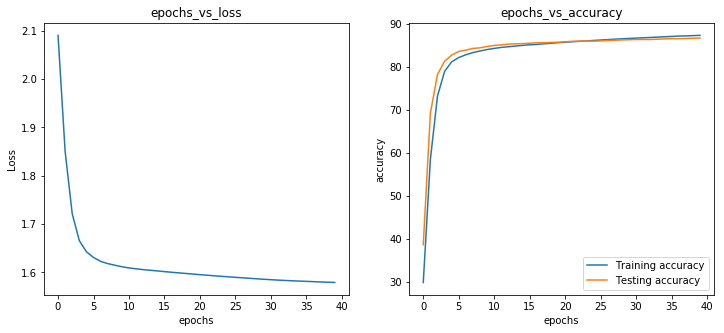

In [70]:
fit(mlp, train_loader, epochs=40, optimizer='Adam', loss='CrossEntropy')